In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']  # 用来正常显示中文标签
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
import os 


In [3]:
raw_data_list = []
for r,d,fs in os.walk('../data/stock_daily'):
    for f in fs:
        
        if (not ('[DES]' in f)) and ('txt' in f):
            file_path = os.path.join(r,f)
            # print(file_path)
            raw_data_list.append(pd.read_csv(file_path,
                         sep='\t',
                         dtype={'Stkcd': str}))


In [4]:
working_data  =  pd.concat(raw_data_list,axis=0).set_index(['Trddt','Stkcd'])

In [5]:
working_data.drop_duplicates(inplace=True)


In [6]:
adj_price_df = working_data[['Adjprcwd']].unstack('Stkcd')
adj_price_df.columns = adj_price_df.columns.get_level_values(1)
adj_price_df.index = pd.to_datetime(adj_price_df.index)
log_return_df = np.log(adj_price_df.shift(-1)/adj_price_df)

In [7]:
import pandas as pd

def create_monthly_cv(data, step=1, train_size=1, test_size=1):
    """
    基于月份向前推进，创建时间序列数据的训练集和测试集，
    并允许分别指定训练集和测试集的大小，以及-1选项来使用所有可用数据。

    参数:
    data (pd.DataFrame): 带有时间索引的 DataFrame。
    step (int): 每次向前推进的月份数。默认为1个月。
    train_size (int): 每个训练集包含的月份数。
                      如果为 -1，则训练集包含从数据开始到当前测试集开始之前的所有数据。
                      默认为1个月。
    test_size (int): 每个测试集包含的月份数。默认为1个月。

    返回:
    tuple: 包含训练集列表和测试集列表的元组。
    """
    train_list = []
    test_list = []

    # 获取数据的时间范围
    min_date = data.index.min()
    max_date = data.index.max()

    # 确定迭代的起始点
    # 我们需要找到第一个可能的测试集结束日期，这样训练集才不会为空
    # 如果test_size >= 1，那么训练集至少需要是test_size月份的数据
    # 如果train_size = -1，则训练集可以是任意大小，但测试集是关键
    
    # 找到第一个测试集的结束日期
    current_test_end_month = min_date + pd.DateOffset(months=test_size) - pd.Timedelta(days=1)
    
    # 如果第一个测试集结束日期就超过了最大日期，则无法生成任何数据对
    if current_test_end_month > max_date and test_size > 0:
        print("Warning: The specified test_size is too large for the provided data. No data pairs can be generated.")
        return [], []

    # 确立第一个测试集的开始日期
    current_test_start_month = min_date
    
    # 循环生成训练集和测试集对
    while current_test_start_month <= max_date:
        # 计算当前测试集的结束日期
        # 确保不超过数据的最大日期
        current_test_end_month = current_test_start_month + pd.DateOffset(months=test_size) - pd.Timedelta(days=1)
        if current_test_end_month > max_date:
            current_test_end_month = max_date

        # 确定训练集的结束日期
        # 训练集结束于当前测试集开始之前
        train_end_date = current_test_start_month - pd.Timedelta(days=1)

        # 确定训练集的开始日期
        if train_size == -1:
            # 如果 train_size 为 -1，训练集从数据的最小日期开始
            train_start_date = min_date
        else:
            # 否则，训练集从当前测试集开始日期向前推 train_size 个月
            train_start_date = current_test_start_month - pd.DateOffset(months=train_size)

        # 提取训练集数据
        # 确保训练集的开始日期不早于数据的最小日期
        if train_start_date < min_date:
            train_start_date = min_date
            
        # 确保训练集和测试集有重叠（即训练集不为空且测试集不为空）
        # 并且训练集的结束日期必须早于测试集的开始日期
        if train_end_date >= train_start_date and current_test_start_month <= current_test_end_month:
            train_data = data[(data.index >= train_start_date) & (data.index <= train_end_date)]
            test_data = data[(data.index >= current_test_start_month) & (data.index <= current_test_end_month)]

            # 只有当训练集和测试集都非空时，才添加到列表中
            if not train_data.empty and not test_data.empty:
                train_list.append(train_data)
                test_list.append(test_data)
        
        # 推进到下一个测试集的开始日期
        # 确保 step > 0 以避免死循环
        if step <= 0:
            print("Error: step must be a positive integer to avoid infinite loop.")
            break
        
        # 记录推进前的日期，用于检测是否发生变化
        prev_test_start_month = current_test_start_month
        current_test_start_month = current_test_start_month + pd.DateOffset(months=step)
        
        # 如果推进后的日期没有改变（例如，月数不足以进位，或者step=0），则强制推进一天以避免死循环
        if current_test_start_month <= prev_test_start_month:
            current_test_start_month += pd.Timedelta(days=1)
            
        # 如果推进后的测试集开始日期已经超过了数据的最大日期，则结束循环
        if current_test_start_month > max_date:
            break

    return train_list, test_list

In [8]:
# how past can tell future


In [9]:
import numpy as np
from scipy.stats import entropy

def kl_div_core(test_arr1, test_arr2, bins=30, epsilon=1e-10):
    """
    计算两个数组之间KL散度的核心函数
    
    参数:
    test_arr1: 第一个数组（作为真实分布P）
    test_arr2: 第二个数组（作为近似分布Q）
    bins: 直方图的bin数量
    epsilon: 平滑参数，避免除零错误
    
    返回:
    kl_value: KL散度值 D_KL(P || Q)，如果无效数据过多则返回 np.nan
    """
    # 确保输入是numpy数组
    arr1 = np.array(test_arr1)
    arr2 = np.array(test_arr2)
    
    # print('arr1 shape:', arr1.shape, 'arr2 shape:', arr2.shape)    
    # print('arr1 NaNs:', np.sum(~np.isfinite(arr1)), 'arr2 NaNs:', np.sum(~np.isfinite(arr2)))
    
    # 选项1: 过滤 NaN（推荐，明确处理）
    arr1_finite = arr1[np.isfinite(arr1)]
    arr2_finite = arr2[np.isfinite(arr2)]
    
    if len(arr1_finite) <= 100 or len(arr2_finite) <= 100:
        # print("Warning: 至少一个数组无有效值，返回 NaN")
        return np.nan
    
    # 计算范围（用过滤后的值）
    min_val = min(np.min(arr1_finite), np.min(arr2_finite))
    max_val = max(np.max(arr1_finite), np.max(arr2_finite))
    
    # 选项2: 或者用 np.nanmin/np.nanmax 简化（无需过滤，但需检查 hist 非空）
    # min_val = min(np.nanmin(arr1), np.nanmin(arr2))
    # max_val = max(np.nanmax(arr1), np.nanmax(arr2))
    
    # 创建概率直方图
    hist1, bin_edges = np.histogram(arr1_finite, bins=bins, range=(min_val, max_val), density=True)
    hist2, _ = np.histogram(arr2_finite, bins=bin_edges, density=True)
    
    # 添加平滑避免零概率
    hist1 = hist1 + epsilon
    hist2 = hist2 + epsilon
    
    # 重新归一化
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # 计算KL散度
    kl_value = np.sum(hist1 * np.log(hist1 / hist2))
    
    return kl_value

In [10]:
def kl_sr(sr:pd.Series,window:int = 120,gap:int = 20):
    # sr.fillna(inplace= True)
    sr_arr = sr.values
    # print('',-2*window-gap,-window-gap,-gap)
    test_arr1,test_arr2 = sr[-2*window-gap:-window-gap],sr[-window-gap:-gap]
    return kl_div_core(test_arr1,test_arr2)



    

In [11]:
# log_return_df.fillna(-1,inplace=True)
log_return_df

Stkcd,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,920112,920116,920118,920128,920167,920445,920489,920682,920799,920819
Trddt,,,,,,,,,,,,,,,,,,,,,
2010-09-16,0.001202,0.006207,0.008119,0.027274,0.030854,0.022180,0.040524,-0.001708,NaN,0.068617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17,0.002999,-0.001238,-0.001799,-0.029581,-0.059882,-0.005175,-0.007975,-0.029490,NaN,-0.054067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-20,-0.005404,0.009864,0.008068,0.002307,0.005594,0.002591,0.029193,0.007018,NaN,0.013245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-21,0.004805,-0.003688,0.023821,0.004598,0.001394,0.026804,0.000000,0.047791,NaN,-0.008811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-27,-0.026102,-0.028734,-0.000872,-0.016185,-0.012614,0.002516,0.009288,-0.022757,NaN,-0.051060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09,0.001701,0.000000,0.021812,NaN,0.010681,0.003940,0.007067,-0.019838,-0.002176,0.008753,...,-0.015974,0.015818,0.019438,-0.017211,-0.031047,0.011281,-0.012915,0.001905,-0.002771,0.028605
2025-09-10,0.006774,-0.004383,0.009337,NaN,0.006618,0.000000,0.000000,-0.000911,0.006515,-0.001090,...,0.011536,0.012881,-0.011409,0.018975,0.007615,0.019834,0.012915,0.006638,0.014631,-0.004348
2025-09-11,-0.011031,0.015977,-0.027322,NaN,0.009192,-0.007895,0.010508,0.036693,0.029853,0.006522,...,-0.015570,-0.010427,-0.010837,-0.014197,-0.017700,-0.034362,-0.012019,-0.013321,-0.007892,-0.022027


In [12]:
kl_df = log_return_df.apply(lambda x: (kl_sr(x)))
kl_df

Stkcd
000001    1.248025
000002    3.911632
000004    2.148115
000005         NaN
000006    2.324224
            ...   
920445    2.354037
920489    2.959954
920682    0.656918
920799    4.270271
920819    2.583513
Length: 5784, dtype: float64

In [13]:
kl_df

Stkcd
000001    1.248025
000002    3.911632
000004    2.148115
000005         NaN
000006    2.324224
            ...   
920445    2.354037
920489    2.959954
920682    0.656918
920799    4.270271
920819    2.583513
Length: 5784, dtype: float64

In [14]:
zero_kl_stks = kl_df.nsmallest(50).index.to_list()

In [15]:
working_data['ChangeRatio'].unstack(level=1)

Stkcd,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,920112,920116,920118,920128,920167,920445,920489,920682,920799,920819
Trddt,,,,,,,,,,,,,,,,,,,,,
2010-09-16,-0.017139,-0.015931,-0.019538,-0.029083,-0.012113,-0.026958,-0.041997,-0.034596,NaN,0.027810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17,0.001203,0.006227,0.008152,0.027650,0.031335,0.022427,0.041356,-0.001706,NaN,0.071026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-20,0.003003,-0.001238,-0.001797,-0.029148,-0.058124,-0.005161,-0.007943,-0.029060,NaN,-0.052632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-21,-0.005389,0.009913,0.008101,0.002309,0.005610,0.002594,0.029624,0.007042,NaN,0.013333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-27,0.004816,-0.003681,0.024107,0.004608,0.001395,0.027167,0.000000,0.048951,NaN,-0.008772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09,0.004274,0.014793,-0.016965,NaN,-0.022310,-0.002625,-0.003534,0.000894,-0.006479,-0.002193,...,-0.028086,-0.052915,-0.003145,-0.022152,-0.043844,-0.058015,-0.026282,-0.022367,-0.016329,-0.028200
2025-09-10,0.001702,0.000000,0.022052,NaN,0.010738,0.003947,0.007092,-0.019643,-0.002174,0.008791,...,-0.015847,0.015943,0.019628,-0.017064,-0.030570,0.011345,-0.012832,0.001907,-0.002767,0.029018
2025-09-11,0.006797,-0.004373,0.009381,NaN,0.006640,0.000000,0.000000,-0.000911,0.006536,-0.001089,...,0.011603,0.012964,-0.011344,0.019156,0.007645,0.020032,0.012999,0.006660,0.014739,-0.004338


In [16]:
kl_df

Stkcd
000001    1.248025
000002    3.911632
000004    2.148115
000005         NaN
000006    2.324224
            ...   
920445    2.354037
920489    2.959954
920682    0.656918
920799    4.270271
920819    2.583513
Length: 5784, dtype: float64

In [17]:
(~np.isfinite(kl_df)).sum()

np.int64(393)

In [18]:
# log_return_df[select_list]

In [19]:
## 实验1 在KL散度更低的股票上，预测误差更小
hs_300_stkid = [code.split('.')[0] for code in pd.read_csv('component_hs300_monthly(1).csv')['share_code'].unique()]

hs_300_return_df = log_return_df[hs_300_stkid]


In [20]:
hs_300_return_df

Stkcd,600519,601318,000858,600036,600276,000333,600030,000651,600887,002475,...,000630,688472,688506,601136,600377,601058,301236,302132,688047,001391
Trddt,,,,,,,,,,,,,,,,,,,,,
2010-09-16,0.015383,-0.003480,0.027784,0.003899,0.032513,NaN,-0.009835,-0.011470,0.055464,-0.045474,...,0.019982,NaN,NaN,NaN,-0.005882,NaN,NaN,NaN,NaN,NaN
2010-09-17,0.017399,0.024713,0.002106,0.003108,0.000000,NaN,-0.018133,NaN,0.000493,-0.027780,...,-0.024273,NaN,NaN,NaN,0.008811,NaN,NaN,NaN,NaN,NaN
2010-09-20,0.008648,0.005189,-0.000902,-0.001553,0.037109,NaN,-0.000915,NaN,-0.021153,-0.071882,...,-0.018599,NaN,NaN,NaN,0.007283,NaN,NaN,NaN,NaN,NaN
2010-09-21,0.016423,0.024964,0.015814,-0.002334,0.002798,NaN,0.001830,0.003527,0.025821,0.032311,...,0.047060,NaN,NaN,NaN,0.008671,NaN,NaN,NaN,NaN,NaN
2010-09-27,0.011484,-0.009754,0.032904,-0.018075,-0.010030,NaN,-0.028746,-0.022073,0.033264,-0.038900,...,0.019510,NaN,NaN,NaN,0.001438,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09,0.011239,-0.002244,-0.005762,0.003961,-0.010890,-0.002075,-0.001356,-0.004364,-0.004562,0.007933,...,-0.002307,-0.047984,-0.054437,0.003273,-0.003786,-0.003925,0.003934,0.013618,0.000888,-0.004454
2025-09-10,0.000978,0.014070,0.003586,0.006953,-0.029293,0.000000,0.028425,0.005089,0.010149,0.095329,...,0.025087,-0.002420,0.014443,0.016208,-0.003040,0.013149,0.032555,0.027174,0.043662,0.004454
2025-09-11,-0.004935,-0.017359,-0.010403,-0.017708,0.010488,-0.019006,-0.018300,-0.007765,-0.016500,-0.003598,...,0.065383,-0.022051,0.005130,-0.016675,-0.010712,-0.019124,-0.001268,0.001569,0.004317,-0.002967


In [21]:
## 实验2 KL散度小的股票等权更好
def block_MSE(X, Y):
    """
    X,Y是形状相同的np array,展平后计算mse
    """
    xf = X.flatten()
    yf = Y.flatten()
    valid_mask = (np.isfinite(xf)& np.isfinite(yf))
    none_one_mask = ~((xf==1) |(yf==1))
    x_valid = xf[valid_mask&none_one_mask]
    y_valid = yf[valid_mask&none_one_mask]
    
    return np.nanmean((x_valid- y_valid) ** 2)

def block_coef(X, Y):
    """
    X,Y是形状相同的np array,展平后计算mse
    """
    xf = X.flatten()
    yf = Y.flatten()
    valid_mask = (np.isfinite(xf)& np.isfinite(yf))
    none_one_mask = ~((xf==1) |(yf==1))
    x_valid = xf[valid_mask&none_one_mask]
    y_valid = yf[valid_mask&none_one_mask]
    # print('valids shape' ,x_valid.shape)
    coef_matrix = np.corrcoef(x_valid,y_valid)
    return coef_matrix[0, 1]
    # return np.coef((X.flatten(),Y.flatten()))

In [22]:
train_list, test_list = create_monthly_cv(hs_300_return_df['2011-01-01':],train_size = 12,test_size = 2)

In [34]:
cov_mses = []
for idx in range(len(train_list)):
    train = train_list[idx]
    test = test_list[idx]
    raw_columns = train.sample(n=300, axis=1)
    raw_train_cov = raw_columns.corr() 
    raw_test_cov = test[raw_columns.columns].corr()
    full_mse = block_MSE(raw_train_cov.values,raw_test_cov.values)
    full_coef  = block_coef(raw_train_cov.values,raw_test_cov.values)
             
    kl_df_test =  test.apply(lambda x: (kl_sr(x)))
    select_stks = kl_df_test.nsmallest(50).index.to_list()
    select_train_cov = train[select_stks].corr()
    select_test_cov = test[select_stks].corr()

    select_mse = block_MSE(select_train_cov.values,select_test_cov.values)
    selcet_coef = block_coef(select_train_cov.values,select_test_cov.values)

    cov_mses.append({
        'date': test.index[0],
        # 'full_mse':full_mse,
        # 'select_mse':select_mse,
        '全样本相关性':full_coef,
        'KL选择后相关性':selcet_coef,
            
    })
    

In [35]:
mses = pd.DataFrame(cov_mses).set_index('date')

In [36]:
# mses['excess_mse'] = (mses['full_mse'] - mses['select_mse'])
# mses['excess_mse'].mean()/mses['excess_mse'].std()


In [37]:
mses['excess_coef'] =   mses['KL选择后相关性'] - mses['全样本相关性']
mses['excess_coef'].mean()/mses['excess_coef'].std()

np.float64(1.9177411135092919)

<Axes: xlabel='date'>

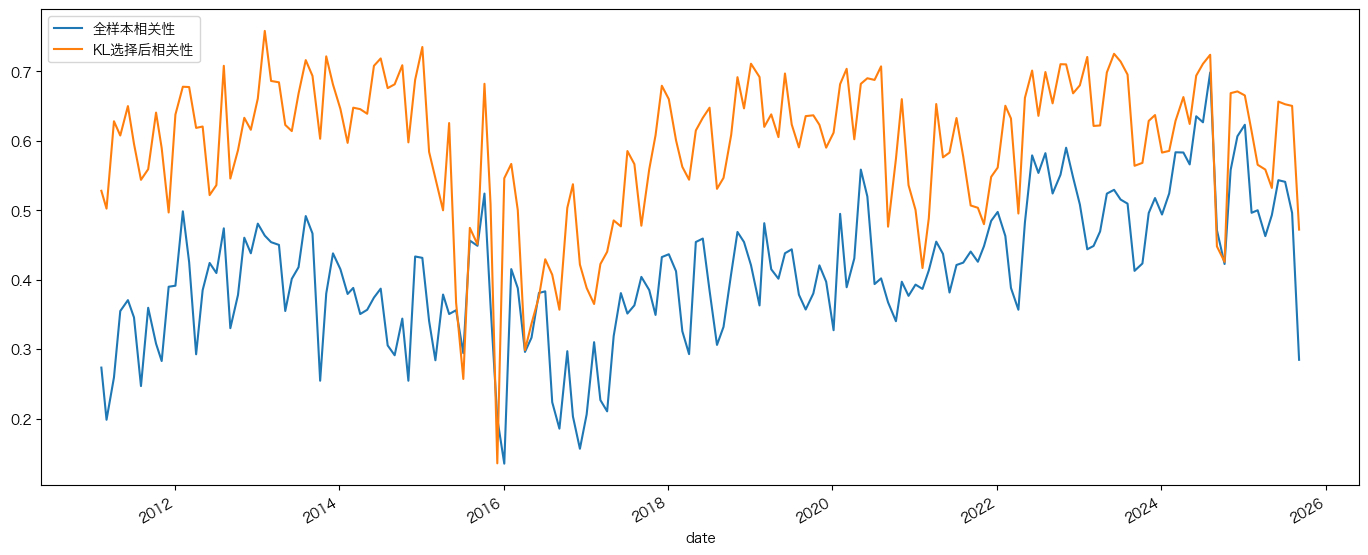

In [38]:
mses[['全样本相关性','KL选择后相关性']].plot(figsize=(17,7))